In [ ]:
# pre-trained model web/model에 있음

In [44]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as data

from torchvision import transforms, datasets
# from torchvision import prototype as P
from sklearn.metrics import classification_report

from tqdm.auto import tqdm


In [45]:
EPOCHS = 10 # 1
BATCH_SIZE = 16
LEARNING_RATE = 0.0001

In [46]:
# 데이터 경로
dataset_path = "datasets/project_datas/"

# duplication code만 적용한 데이터
TRAIN_DATA_PATH = dataset_path + "train/"
VALID_DATA_PATH = dataset_path + "valid/"
TEST_DATA_PATH = dataset_path + "test/"

# Normalize용 mean 및 std (ResNet50에서 학습할 때 다음 설정으로 했음)
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

# 학습용 transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

# 학습용 transform (데이터 개수 늘리는 증강 적용할 때 사용)
aug_transform1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=1),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])
aug_transform2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

# Norm 만 적용 (for valid, test)
initial_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])


# Data load
# # 증강 방법 1 = 원본 이미지에 상하(p=0.5), 좌우(p=0.5), 밝기(0.2)적용 = 2793장
# train_data = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=train_transform)
# # 증강 방법 2 = 원본 이미지 + 상하반전(밝기0.2) + 좌우반전(밝기0.2) = 2793 * 3 = 8379장
# 증강 방법 2를 사용해서 학습 진행
train_data = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=initial_transform)
train_data += datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=aug_transform1)
train_data += datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=aug_transform2)    

valid_data = datasets.ImageFolder(root=VALID_DATA_PATH, transform=initial_transform)
test_data = datasets.ImageFolder(root=TEST_DATA_PATH, transform=initial_transform)

train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_data_loader = data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_data_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

tensor([ 8, 32, 23, 13, 32,  0, 14,  2,  4,  7, 22,  5, 12,  2,  7, 19])
torch.Size([16, 3, 224, 224])

원본 이미지(norm 제거)


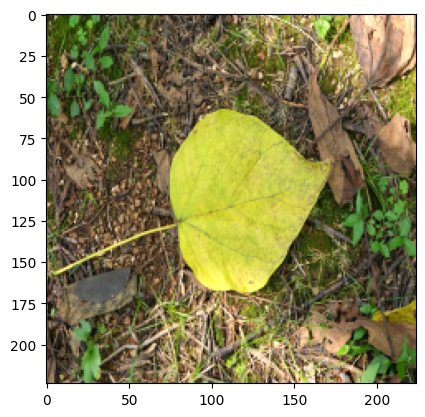

norm 적용 이미지


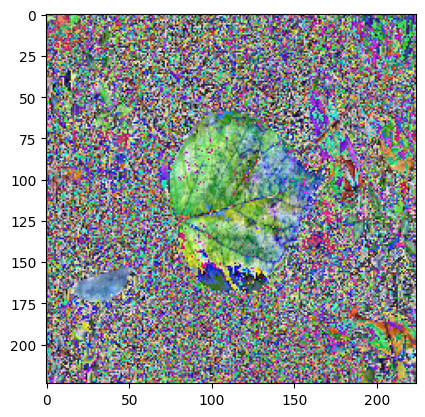

In [47]:
# data_loader의 이미지 및 shape, label 확인
topilimage = transforms.ToPILImage()
for img, label in train_data_loader:
    print(label)
    print(img.shape)
    remove_norm_img = topilimage(img[0]*torch.tensor(norm_std)[:, None, None] + torch.tensor(norm_mean)[:, None, None])
    normed_img = topilimage(img[0])
    
    print("\n원본 이미지(norm 제거)")
    plt.imshow(remove_norm_img)
    plt.show()
    
    print("norm 적용 이미지")
    plt.imshow(normed_img)
    plt.show()
    break

In [48]:
# 불러온 data class 순서, 개수 확인
class_dict = valid_data.class_to_idx
print(class_dict)

CLASS_NUM = len(class_dict)
print("Class 개수: ", CLASS_NUM)

# 꽃개오동 참취 곰취 개오동

# train, valid, test 개수 확인
print(f"train_num: {len(train_data)}\
      \nvalid_num: {len(valid_data)}\
      \ntest_num: {len(test_data)}")

{'가는장구채': 0, '가시박': 1, '가지': 2, '개여뀌': 3, '개오동': 4, '개옻나무': 5, '곰취': 6, '까마중': 7, '꽃개오동': 8, '능소화': 9, '닥풀': 10, '담배풀': 11, '대청부채': 12, '도깨비가지': 13, '독미나리': 14, '맑은대쑥': 15, '묏미나리': 16, '미국까마중': 17, '미국능소화': 18, '미나리': 19, '범부채': 20, '분홍장구채': 21, '붉나무': 22, '술패랭이꽃': 23, '아까시나무': 24, '어저귀': 25, '여뀌': 26, '여우오줌': 27, '왕자귀나무': 28, '자귀나무': 29, '장구채': 30, '제비쑥': 31, '좀담배풀': 32, '진득찰': 33, '쪽': 34, '참취': 35, '털진득찰': 36, '패랭이꽃': 37, '하늘타리': 38, '회화나무': 39}
Class 개수:  40
train_num: 90837      
valid_num: 4911      
test_num: 7516


In [49]:
# train device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

# model load
# 사용한 모델 => https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights="ResNet50_Weights.IMAGENET1K_V2")

# class 분류용 FC layer 추가
cf_fc1 = nn.Linear(1000, 512)
cf_fc2 = nn.Linear(512, CLASS_NUM)
model.add_module('CF_fc1', cf_fc1)
model.add_module('CF_fc2', cf_fc2)

## model GPU로 넘김
## Multi GPU: gpu 여러개일 때 DataParallel 사용, train 및 valid 부분도 수정해줘야함
# model = torch.nn.DataParallel(model).to(device) 
## Single GPU
model = model.to(device)

# optim 및 loss_func 설정        
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = torch.nn.CrossEntropyLoss()

device:  cuda


Using cache found in C:\Users\kser/.cache\torch\hub\pytorch_vision_v0.10.0


In [50]:
# model 파라미터 및 구조 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

print(model)

26090064
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), st

In [51]:
# 학습 결과 저장 폴더 이름 및 경로 지정
save_path = 'model_save/train_1/'

if os.path.isdir(save_path) == True:
    print("!! 저장할 폴더와 동일한 이름의 폴더가 이미 존재합니다.")
else:
    print(f"{save_path} 경로에 저장 폴더가 생성되었습니다. ")
    os.makedirs(save_path)

!! 저장할 폴더와 동일한 이름의 폴더가 이미 존재합니다.


In [53]:
def train(model, trainloader, optimizer, loss_function, epoch, log_inter):
    model.train()
    # print(model)
    for batch_idx, (image, label) in enumerate(trainloader):
        image = image.to(device)
        label = label.to(device)
        # Forward pass
        output = model(image)
        # output = model.module.CF_fc(output) # DP사용할 때
        output = model.CF_fc1(output)
        output = model.CF_fc2(output)
        loss = loss_function(output, label)

        # Backward and optimize
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        # Printing the result at the specific interval
        if batch_idx % log_inter == 0: # log_inter = 100
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx, len(trainloader), 100. * batch_idx / len(trainloader),
                loss.item()))
            with open(save_path + 'result.txt', 'a') as f:
                f.write("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}\n".format(
                epoch, batch_idx, len(trainloader), 100. * batch_idx / len(trainloader),
                loss.item()))
                
def valid(model, validloader, batch_size, loss_function):
    model.eval()
    valid_loss = 0
    correct = 0

    with torch.no_grad():
        # 각 class별 f1-score 및 acc 계산용 array 저장
        all_pre = np.array([])
        all_lab = np.array([])
        
        for i, (image, label) in enumerate(tqdm(validloader)):
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            # 분류를 위한 FC layer 추가
            output = model.CF_fc1(output)
            output = model.CF_fc2(output)
            # output = model.module.CF_fc(output) # DP사용할 때
            
            valid_loss += loss_function(output, label).item()    
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
                
            # 각 클래스별 f1-score 및 accuracy 계산을 위한 결과 저장
            tmp = prediction.squeeze(-1).cpu().numpy()
            tmp2 = label.cpu().numpy()
                
            # 모든 class의 f1-score 계산
            if all_pre.size == 0:
                all_pre = tmp
            else:
                all_pre = np.concatenate((all_pre, tmp))
            if all_lab.size == 0:
                all_lab = tmp2
            else:
                all_lab = np.concatenate((all_lab, tmp2))
    
    valid_loss /= (len(validloader.dataset) / batch_size)
    valid_accuracy = 100. * correct / len(validloader.dataset)
    return valid_loss, valid_accuracy, all_pre, all_lab

In [54]:
# model 저장용 valid_loss 설정
best_valid_loss = 100

# 전체 학습 진행
for epoch in range(0, EPOCHS):
    # train 학습 진행
    train(model, train_data_loader, optimizer, loss_function, epoch, log_inter = 2)
    
    # validation data에 대해서 평가
    valid_loss, valid_accuracy, all_pre, all_lab = valid(model, valid_data_loader, BATCH_SIZE, loss_function)
    
    # 각 클래스별 f1 score 계산 및 출력
    f1_scores = classification_report(all_lab, all_pre, digits=4)
    print(f1_scores)
    
    # 각 클래스별 accuracy 계산 및 출력
    class_acc = []
    for j in range(CLASS_NUM):
        class_acc.append(len(np.where((all_pre != j) & (all_lab != j))[0]) + \
            len(np.where((all_pre == j) & (all_lab == j))[0])) / len(all_lab)
        print("Class {0} accuracy : {1}".format(j, (len(np.where((all_pre != j) & (all_lab != j))[0]) + \
            len(np.where((all_pre == j) & (all_lab == j))[0])) / len(all_lab)))

    # val_loss 기준으로 best 모델을 저장
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model = f'epoch_{epoch}_val_{round(valid_loss, 2)}.pt'
        torch.save(model, save_path+best_model)

    # epoch마다 학습 결과를 파일로 저장    
    with open(save_path + 'result.txt', 'a') as f:
        f.write(f"\n[EPOCH: {epoch}/{EPOCHS}],\
            \nValid Loss: {valid_loss}, \
            \nValid Accuracy: {valid_accuracy}% \
            \n\nf1-score: {f1_scores} \
            \nclass_dict: {class_dict},\nclass_acc: {class_acc}\n\n")

Train Epoch: 0 [0/5678 (0%)]	Train Loss: 3.701018
Train Epoch: 0 [2/5678 (0%)]	Train Loss: 3.556093
Train Epoch: 0 [4/5678 (0%)]	Train Loss: 3.564479
Train Epoch: 0 [6/5678 (0%)]	Train Loss: 3.508634
Train Epoch: 0 [8/5678 (0%)]	Train Loss: 3.212789
Train Epoch: 0 [10/5678 (0%)]	Train Loss: 3.689198
Train Epoch: 0 [12/5678 (0%)]	Train Loss: 3.829062
Train Epoch: 0 [14/5678 (0%)]	Train Loss: 3.400376
Train Epoch: 0 [16/5678 (0%)]	Train Loss: 2.991346
Train Epoch: 0 [18/5678 (0%)]	Train Loss: 3.532156
Train Epoch: 0 [20/5678 (0%)]	Train Loss: 2.766495
Train Epoch: 0 [22/5678 (0%)]	Train Loss: 3.203138
Train Epoch: 0 [24/5678 (0%)]	Train Loss: 3.603987
Train Epoch: 0 [26/5678 (0%)]	Train Loss: 2.704449
Train Epoch: 0 [28/5678 (0%)]	Train Loss: 3.138784
Train Epoch: 0 [30/5678 (1%)]	Train Loss: 3.373622
Train Epoch: 0 [32/5678 (1%)]	Train Loss: 3.090722
Train Epoch: 0 [34/5678 (1%)]	Train Loss: 3.437922
Train Epoch: 0 [36/5678 (1%)]	Train Loss: 3.407653
Train Epoch: 0 [38/5678 (1%)]	Train 

100%|██████████| 307/307 [00:45<00:00,  6.70it/s]


              precision    recall  f1-score   support

           0     0.9255    0.7632    0.8365       114
           1     0.9688    0.9208    0.9442       101
           2     0.9854    0.9759    0.9806       622
           3     0.8723    0.7593    0.8119       108
           4     0.5852    0.9634    0.7281        82
           5     0.9760    0.9368    0.9560       174
           6     0.8214    0.9829    0.8949       117
           7     0.6109    0.9060    0.7297       149
           8     0.9545    0.3925    0.5563       107
           9     0.8367    0.8817    0.8586        93
          10     0.9721    0.9355    0.9534       186
          11     0.9259    0.4425    0.5988       113
          12     0.6176    0.3500    0.4468        60
          13     0.9375    0.9375    0.9375        96
          14     0.8879    0.7724    0.8261       123
          15     0.9060    0.8413    0.8724       126
          16     0.9868    0.7979    0.8824        94
          17     0.3200    

c:\Users\kser\Anaconda3\envs\sgmse\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Train Epoch: 1 [10/5678 (0%)]	Train Loss: 0.083812
Train Epoch: 1 [12/5678 (0%)]	Train Loss: 0.018300
Train Epoch: 1 [14/5678 (0%)]	Train Loss: 0.122725
Train Epoch: 1 [16/5678 (0%)]	Train Loss: 0.611779
Train Epoch: 1 [18/5678 (0%)]	Train Loss: 0.126442
Train Epoch: 1 [20/5678 (0%)]	Train Loss: 0.103842
Train Epoch: 1 [22/5678 (0%)]	Train Loss: 0.098535
Train Epoch: 1 [24/5678 (0%)]	Train Loss: 0.226414
Train Epoch: 1 [26/5678 (0%)]	Train Loss: 0.143695
Train Epoch: 1 [28/5678 (0%)]	Train Loss: 0.047714
Train Epoch: 1 [30/5678 (1%)]	Train Loss: 0.046821
Train Epoch: 1 [32/5678 (1%)]	Train Loss: 0.102963
Train Epoch: 1 [34/5678 (1%)]	Train Loss: 0.065900
Train Epoch: 1 [36/5678 (1%)]	Train Loss: 0.011435
Train Epoch: 1 [38/5678 (1%)]	Train Loss: 0.241541
Train Epoch: 1 [40/5678 (1%)]	Train Loss: 0.239021
Train Epoch: 1 [42/5678 (1%)]	Train Loss: 0.070526
Train Epoch: 1 [44/5678 (1%)]	Train Loss: 0.693630
Train Epoch: 1 [46/5678 (1%)]	Train Loss: 0.124507
Train Epoch: 1 [48/5678 (1%)]	T

KeyboardInterrupt: 

In [57]:
# 학습된 model 불러오기
print("불러온 모델: ", save_path+best_model, "\n")
model = torch.load(save_path+best_model) ## 학습 진행 후 바로 best_model load
print(model)

불러온 모델:  model_save/train_1/epoch_0_val_0.59.pt 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0

In [58]:
# test dataset에 대한 평가 진행
test_loss, test_accuracy, all_pre, all_lab = valid(model, test_data_loader, BATCH_SIZE, loss_function)

print()
print(class_dict)
print()
for j in range(CLASS_NUM):
    print("Class {0} accuracy : {1}".format(j, (len(np.where((all_pre != j) & (all_lab != j))[0]) + \
        len(np.where((all_pre == j) & (all_lab == j))[0])) / len(all_lab)))

print()
print("\nf1-scores...\n")
print(classification_report(all_lab, all_pre, digits=4))

100%|██████████| 470/470 [01:11<00:00,  6.57it/s]


{'가는장구채': 0, '가시박': 1, '가지': 2, '개여뀌': 3, '개오동': 4, '개옻나무': 5, '곰취': 6, '까마중': 7, '꽃개오동': 8, '능소화': 9, '닥풀': 10, '담배풀': 11, '대청부채': 12, '도깨비가지': 13, '독미나리': 14, '맑은대쑥': 15, '묏미나리': 16, '미국까마중': 17, '미국능소화': 18, '미나리': 19, '범부채': 20, '분홍장구채': 21, '붉나무': 22, '술패랭이꽃': 23, '아까시나무': 24, '어저귀': 25, '여뀌': 26, '여우오줌': 27, '왕자귀나무': 28, '자귀나무': 29, '장구채': 30, '제비쑥': 31, '좀담배풀': 32, '진득찰': 33, '쪽': 34, '참취': 35, '털진득찰': 36, '패랭이꽃': 37, '하늘타리': 38, '회화나무': 39}

Class 0 accuracy : 0.9978712080894092
Class 1 accuracy : 0.9988025545502927
Class 2 accuracy : 0.9996008515167643
Class 3 accuracy : 0.9964076636508781
Class 4 accuracy : 0.9974720596061735
Class 5 accuracy : 0.9972059606173497
Class 6 accuracy : 0.9980042575838212
Class 7 accuracy : 0.9869611495476317
Class 8 accuracy : 0.9982703565726451
Class 9 accuracy : 0.9934805747738159
Class 10 accuracy : 0.9989356040447046
Class 11 accuracy : 0.99654071314529
Class 12 accuracy : 0.9926822778073443
Class 13 accuracy : 0.9994678020223523
Class 14 ac